# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

#### Описание данных
Технологический процесс  
Rougher feed — исходное сырье  
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
Xanthate ** — ксантогенат (промотер, или активатор флотации);  
Sulphate — сульфат (на данном производстве сульфид натрия);  
Depressant — депрессант (силикат натрия).  
Rougher process (англ. «грубый процесс») —  флотация   
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота  

#### Параметры этапов  
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи  

#### Наименование признаков
Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag  
Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  
Возможные значения для блока [тип_параметра]:  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  



## Подготовка данных

KNNImputer никак не хотел импортироваться, поэтому пришлось апгрейдить библиотеку scikit-learn.

In [1]:
pip install -U scikit-learn --user

Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.24.2)
Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек 

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.pipeline import  make_pipeline
pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import collections

Открываем файлы и изучаем на наличие аномалий, пропусков и ошибок. 

In [3]:
test_frame = pd.read_csv('/datasets/gold_recovery_test_new.csv')
train_frame = pd.read_csv('/datasets/gold_recovery_train_new.csv')
full_frame = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Посмотрим структуру датасетов на примере обучающей выборки.

In [4]:
train_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

У нас имеется 87 столбцов и 14149 строк в обучающей выборке. Для обучения модели, для конкретно поставленной задачи предсказания коэффициента восстановления золота из золотосодержащей руды нам не понадобятся все столбцы из датасетов. Соответственно, не нужно обрабатывать все колонки и тратить на них свое драгоценное время. Видим, что пропущенные значения имеются во многих столбцах, но их доля невелика. Тип данных во всех столбцах, кроме даты, float64 числовой. 

In [5]:
display(train_frame.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. Для этого создадим функцию для подсчета эффективности обогащения, где:  
output_au — доля золота в концентрате после флотации/очистки;  
input_au — доля золота в сырье/концентрате до флотации/очистки;  
output_tail — доля золота в отвальных хвостах после флотации/очистки.  

In [6]:
def apply_recovery(row):
    (input_au,
     output_au,
     output_tail) = (row["rougher.input.feed_au"],
                     row["rougher.output.concentrate_au"],
                     row["rougher.output.tail_au"])
    recovery_metric = (((output_au) * ((input_au) - (output_tail)))/
                       (((input_au) * ((output_au) - (output_tail))))) * 100
    return recovery_metric

In [7]:
test = train_frame.dropna(subset = ["rougher.input.feed_au",
                                    "rougher.output.concentrate_au",
                                    "rougher.output.tail_au",
                                    "rougher.output.recovery"],axis = 0).apply(
                                                                        apply_recovery,axis = 1)

In [8]:
MAE(train_frame.dropna(subset = ["rougher.input.feed_au",
                                    "rougher.output.concentrate_au",
                                    "rougher.output.tail_au",
                                    "rougher.output.recovery"])["rougher.output.recovery"],
                       test)


9.682896147825551e-15

Значение метрики МАЕ в порядке e-15. Это говорит о том, что расчитанные данные и данные в таблице по recovery равны и рассчитаны верно. Идем дальше. 

Проанализируем признаки, недоступные в тестовой выборке. Посмотрим, что это за параметры, и к какому типу относятся. Создадим переменную list_columns, в которую войдут все столбцы, не вошедшие в тестовую выборку. 

In [9]:
list_columns = set(full_frame.columns) - set(test_frame.columns)
list_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [10]:
step = collections.Counter()
type_step = collections.Counter()
data = collections.Counter()
for i in list_columns:
    words = list(map(str,i.split(".")))
    step[words[0]] += 1
    type_step[words[1]] += 1
    data[words[2]] += 1

In [11]:
step,"\n",type_step,"\n",data

(Counter({'final': 9,
          'rougher': 13,
          'primary_cleaner': 8,
          'secondary_cleaner': 4}),
 '\n',
 Counter({'output': 30, 'calculation': 4}),
 '\n',
 Counter({'concentrate_sol': 3,
          'tail_ag': 4,
          'tail_pb': 4,
          'concentrate_pb': 3,
          'concentrate_au': 3,
          'recovery': 2,
          'concentrate_ag': 3,
          'tail_au': 4,
          'tail_sol': 4,
          'sulfate_to_au_concentrate': 1,
          'floatbank10_sulfate_to_au_feed': 1,
          'au_pb_ratio': 1,
          'floatbank11_sulfate_to_au_feed': 1}))

Получилось, что данные разделились на две категории:

Расчетные, которые получаются из других данных(например rougher.calculation и final.output.recovery)  
Измеряемые, которые являются изначальными параметрами продукта (например final.output.concentrate_au и rougher.output.tail_sol).

Видим, что на всех этапах отсутствует информация о хвостовых частях.

Теперь проверим возможность восстановления параметра recovery.

In [12]:
train_frame = train_frame.dropna(subset=["rougher.output.recovery","final.output.recovery"],axis = 0)

Наконец, проведем предобработку данных.Обработаем пропуски.  
Воспользуемся KNNImputer из sklearn.impute, заполняющий пропуски средним от указанных соседних значений в обучающей выборке:

In [13]:
imputer = KNNImputer()
without_nan = pd.DataFrame(data = imputer.fit_transform(train_frame.drop(['date'],axis = 1)),
             columns= train_frame.drop(['date'],axis = 1).columns,
             index = train_frame.index)

Так как в тестовой выборке отсутствует некоторое количесвто столбцов, в том числе rougher.output.recovery и final.output.recovery, которые понадобятся для обучения модели, то объединим тестовую выборку с исходными данными по дате.

In [14]:
test_frame = test_frame.dropna(subset= ['date'],axis = 0)

In [15]:
test_frame_for_target = test_frame.merge(full_frame.loc[:,['date',"rougher.output.recovery","final.output.recovery"]],
                                         on = 'date')
test_frame_for_target.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.5

Дропнем пропущенные значения в нужных столбцах и затем выделим наши два целевых признака по тестовой выборке. 
И наконец, воспользуемся снова KNNImputer из sklearn.impute, заполняющий пропуски средним от указанных соседних значений, но уже в втестовой выборке.

In [16]:
test_frame_for_target = test_frame_for_target.dropna(subset=["rougher.output.recovery","final.output.recovery"],
                                                     axis = 0)

In [17]:
test_frame = test_frame_for_target.loc[:,test_frame.columns]

In [18]:
target_test_rougher = test_frame_for_target["rougher.output.recovery"]
target_test_final = test_frame_for_target["final.output.recovery"]

In [19]:
test_frame = test_frame.drop("date",axis =1)

In [20]:
imputer_test = KNNImputer()
test_without_nan = pd.DataFrame(data = imputer_test.fit_transform(test_frame), 
                                columns= test_frame.columns, 
                                index = test_frame.index)

### Выводы

1. Данные предобработаны для дальнейшего анализа и построения моделей.  
2. Эффективность обогащения рассчитана правильно. MAE между нашими расчётами и значением признака одинаковы.Значение метрики МАЕ в порядке e-15. Это говорит о том, что расчитанные данные и данные в таблице по recovery равны и рассчитаны верно. 
Проанализированы признаки, недоступные в тестовой выборке. 
Получилось, что отсутствующие данные разделились на две категории:
Расчетные, которые получаются из других данных(например rougher.calculation и final.output.recovery)
Измеряемые, которые являются изначальными параметрами продукта (например final.output.concentrate_au и rougher.output.tail_sol). 
3. Для обучения модели нам понадобятся недостающие значения rougher.output.recovery и final.output.recovery, которые мы благополучно смогли добавить в тестовую выборку с помощью merge. 

## Анализ данных

 Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [21]:
print("Концентрация до флотации")
print("Концентрация Серебра:{: 0.2f},Свинца:{: 0.2f},Золота:{: 0.2f}".
format(without_nan["rougher.input.feed_ag"].mean(),
without_nan["rougher.input.feed_pb"].mean(),
without_nan["rougher.input.feed_au"].mean()))
print()
print("Концентрация после флотации")
print("Коцентрация Серебра:{: 0.2f},Свинца:{: 0.2f},Золота:{: 0.2f}".
format(without_nan["rougher.output.concentrate_ag"].mean(),
without_nan["rougher.output.concentrate_pb"].mean(),
without_nan["rougher.output.concentrate_au"].mean()))
print()
print("Концентрация после первичной очистки")
print("Концентрация Серебра:{: 0.2f},Свинца:{: 0.2f},Золота:{: 0.2f}".
format(without_nan["primary_cleaner.output.concentrate_ag"].mean(),
without_nan["primary_cleaner.output.concentrate_pb"].mean(),
without_nan["primary_cleaner.output.concentrate_au"].mean()))
print()
print("Концентрация поле вторичной очистки")
print("Концентрация Серебра:{: 0.2f},Свинца:{: 0.2f},Золота:{: 0.2f}".
format(without_nan["final.output.concentrate_ag"].mean(),
without_nan["final.output.concentrate_pb"].mean(),
without_nan["final.output.concentrate_au"].mean()))

Концентрация до флотации
Концентрация Серебра: 8.58,Свинца: 3.52,Золота: 7.87

Концентрация после флотации
Коцентрация Серебра: 11.78,Свинца: 7.66,Золота: 19.44

Концентрация после первичной очистки
Концентрация Серебра: 8.20,Свинца: 9.58,Золота: 32.39

Концентрация поле вторичной очистки
Концентрация Серебра: 5.14,Свинца: 10.13,Золота: 44.00


In [22]:
df_concentrate = train_frame[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au',
                           'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag',
                           'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb',
                           'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]

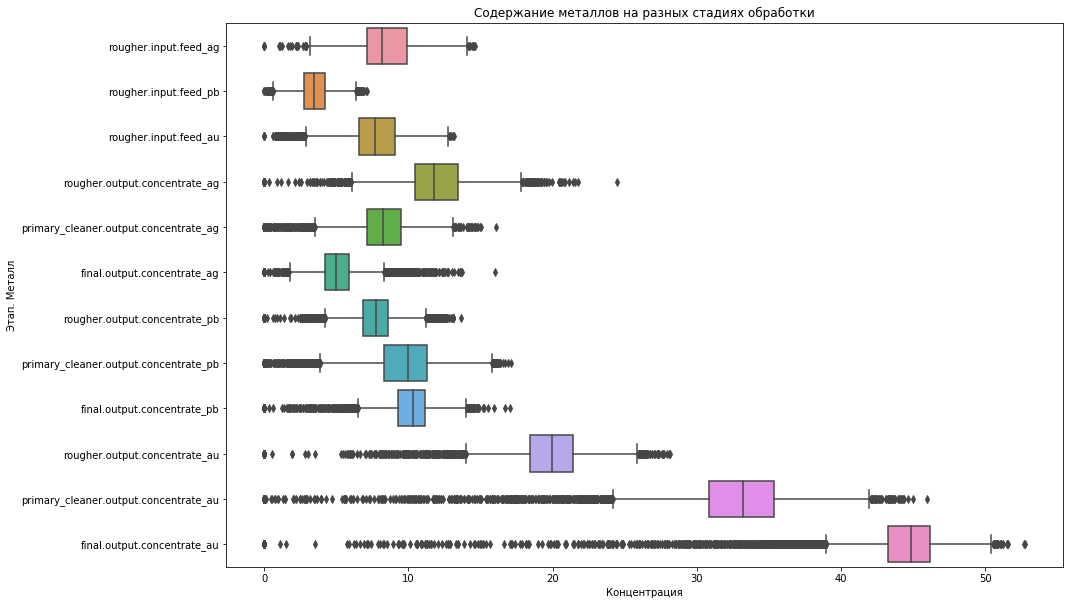

In [23]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df_concentrate, orient='h').set(xlabel='Концентрация', 
                                                 ylabel='Этап. Металл', 
                                                 title='Содержание металлов на разных стадиях обработки');

In [24]:
df_concentrate.describe()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,14149.000000,14049.000000,14149.000000,14149.000000,14149.000000,14148.000000,14149.000000,14063.000000,14148.000000,14149.000000,14149.000000,14149.000000
mean,8.579195,3.522778,7.866577,11.775812,8.200916,5.142034,7.664555,9.588862,10.132960,19.439958,32.386836,44.003792
std,1.896284,1.073394,1.919506,2.731747,2.005185,1.369586,1.856279,2.694296,1.654930,3.765192,5.798843,4.905261
min,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.132802,2.780010,6.596217,10.486871,7.107126,4.211620,6.850501,8.333489,9.297355,18.432161,30.857764,43.276111
50%,8.156092,3.422677,7.649138,11.747362,8.226247,4.994652,7.760435,9.933520,10.297144,19.947312,33.225835,44.872436
75%,9.918304,4.226107,9.066976,13.426419,9.504924,5.859540,8.601927,11.310817,11.170603,21.392714,35.330145,46.166425
max,14.596026,7.142594,13.126043,24.480271,16.081632,16.001945,13.617072,17.081278,17.031899,28.146838,45.933934,52.756638


По представленным выше данным отчетливо видно, что с каждым этапом увеличивается концентрация золота и немного свинца, в то время как концентрация серебра уменьшается.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

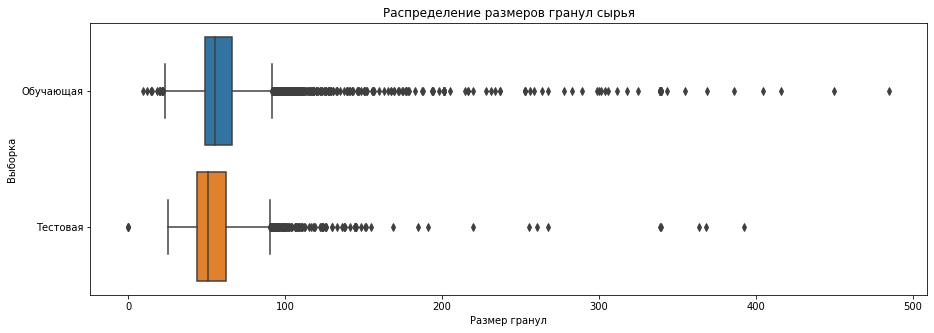

In [25]:
plt.figure(figsize=(15,5))
sns.boxplot(data=(train_frame['rougher.input.feed_size'], 
                  test_frame['rougher.input.feed_size']), orient='h').set(xlabel='Размер гранул', 
                                                                          ylabel='Выборка', 
                                                                          title='Распределение размеров гранул сырья')
plt.yticks([0,1], ['Обучающая', 'Тестовая']);

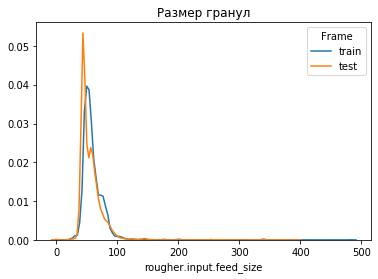

In [26]:
for frame,name in zip([without_nan,test_without_nan],
                       ["train","test"]):
    subset = frame["rougher.input.feed_size"]

    sns.distplot(subset, 
                 hist = False, 
                 kde = True,
                 label = name)
plt.legend(prop={'size': 10}, title = 'Frame')
plt.title('Размер гранул');

Распределения немного отличаются. В обучающей выборке преобладают значения около порога 50 и выше, в то же время как в тестовой выборке достаточно большое количество объектов сконцентрированы до порога 50. Так же это заметно и на средних значениях, среднее значение обучающей выборки немного больше среднего по тестовой выборке. Значит, это не должно оказать существенного влияния на построение модели.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [27]:
def summary_concentarution(row):
    list_of_steps = ["rougher","primary_cleaner","final"]
    input_feed_au = row["rougher.input.feed_au"]
    input_feed_ag = row["rougher.input.feed_ag"]
    input_feed_pb = row["rougher.input.feed_pb"]
    input_feed_sol = row["rougher.input.feed_sol"]
    out_rougher = []
    out_primary_cleaner = []
    out_final = []
    list_of_arrays =[out_rougher,out_primary_cleaner,out_final]
    for step,array in zip(list_of_steps,list_of_arrays):
        array.append(row[step+".output.concentrate_au"])
        array.append(row[step+".output.concentrate_ag"])
        array.append(row[step+".output.concentrate_pb"])
        array.append(row[step+".output.concentrate_sol"])
    sum_before_steps = input_feed_ag+input_feed_au+input_feed_pb+input_feed_sol
    sum_rougher = sum(out_rougher)
    sum_primary = sum(out_primary_cleaner)
    sum_final = sum(out_final)
    return pd.Series([sum_before_steps,sum_rougher,sum_primary,sum_final])

In [28]:
sum_values = without_nan.apply(summary_concentarution,axis = 1)
sum_values.columns = ["before_rougher","rougher","primary_cleaner","final"]

In [29]:
sum_values

,before_rougher,rougher,primary_cleaner,final
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
14144,53.415050,70.781325,59.001692,68.098589
14145,53.696482,70.539603,59.703912,68.274362
14146,54.589604,55.376330,59.561096,68.226068
14147,54.027355,69.201689,57.216686,68.200449


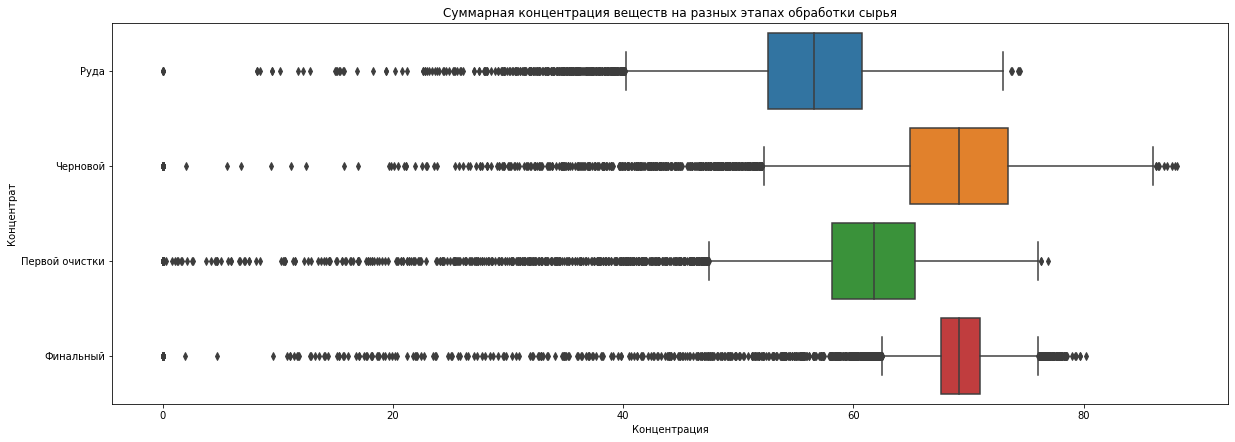

In [30]:
plt.figure(figsize=(20,7))
sns.boxplot(data=(sum_values), orient='h').set(xlabel='Концентрация', 
                                               ylabel='Концентрат', 
                                               title='Суммарная концентрация веществ на разных этапах обработки сырья')
plt.yticks([0,1,2,3], ['Руда', 'Черновой', 'Первой очистки', 'Финальный']);

Можно заметить, что во всех распределениях присутствуют нулевые значения. Они очень далеки от общего распределения, их следует удалить. Так же это стоит проделать и в тестовой выборке, так они носят характер выбросов.

In [31]:
sum_values = sum_values.drop(index = sum_values[sum_values["before_rougher"] < 1].index,
                               axis = 0)
sum_values = sum_values.drop(index = sum_values[sum_values["rougher"] < 1].index,
                               axis = 0)
sum_values = sum_values.drop(index = sum_values[sum_values["primary_cleaner"] < 1].index,
                               axis = 0)
sum_values = sum_values.drop(index = sum_values[sum_values["final"] < 1].index,
                               axis = 0)

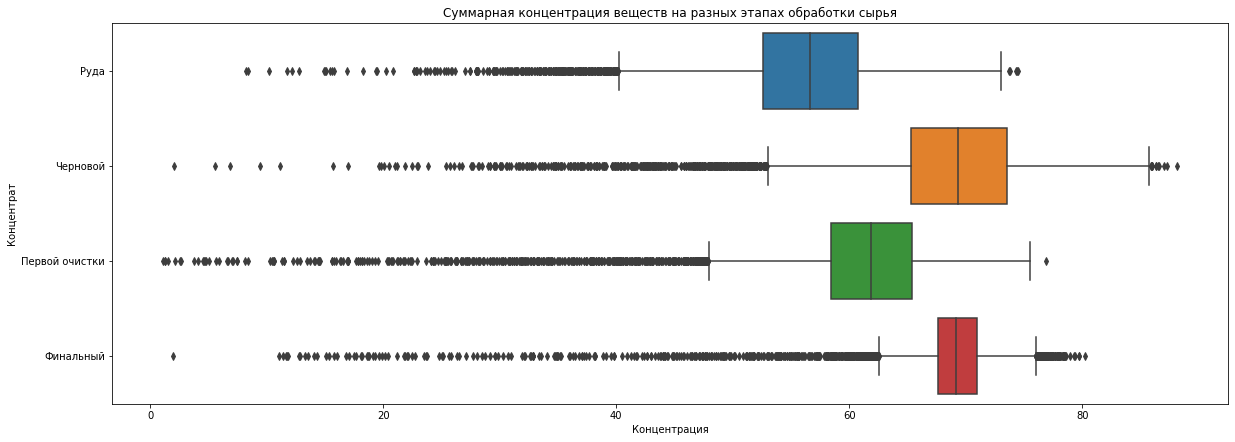

In [32]:
plt.figure(figsize=(20,7))
sns.boxplot(data=(sum_values), orient='h').set(xlabel='Концентрация', 
                                               ylabel='Концентрат', 
                                               title='Суммарная концентрация веществ на разных этапах обработки сырья')
plt.yticks([0,1,2,3], ['Руда', 'Черновой', 'Первой очистки', 'Финальный']);

In [33]:
test_frame = test_frame.drop(index = test_frame[test_frame["rougher.input.feed_au"] < 1].index,
                               axis = 0)
test_frame = test_frame.drop(index = test_frame[test_frame["rougher.input.feed_ag"] < 1].index,
                               axis = 0)
test_frame = test_frame.drop(index = test_frame[test_frame["rougher.input.feed_pb"] < 1].index,
                               axis = 0)
test_frame = test_frame.drop(index = test_frame[test_frame["rougher.input.feed_sol"] < 1].index,
                               axis = 0)

Поле того, как мы избавились от выбросов, перейдем к формированию признаков и целевых признаков в обучающей выборке.

In [34]:
train_features_dataset_rougher = without_nan.loc[:,test_frame.columns]
train_target_dataset_rougher = without_nan['rougher.output.recovery']
train_features_dataset_final = train_features_dataset_rougher 
train_target_dataset_final = without_nan['final.output.recovery'] 

### Выводы

1. В ходе анализа данных было обнаружено, что с каждым этапом обработки увеличивается концентрация золота и немного свинца, в то время как концентрация серебра уменьшается.  
2. Распределения размеров гранул сырья на обучающей и тестовой выборках немного отличаются. В обучающей выборке преобладают значения около порога 50 и выше, в то же время как в тестовой выборке достаточно большое количество объектов сконцентрированы до порога 50. Так же это заметно и на средних значениях, среднее значение обучающей выборки немного больше среднего по тестовой выборке. Значит, это не должно оказать существенного влияния на построение модели.  
3. Суммарная концентрация всех веществ на разных стадиях показала нам, что во всех распределениях присутствуют нулевые значения. Они очень далеки от общего распределения, их нужно было удалить. Аналогично и с тестовой выборкой, так эти нулевые значения носят характер выбросов.

## Модель

Для начала напишем функцию для вычисления итоговой sMAPE - симметричное среднее абсолютное процентное отклонение.

In [35]:
def sMAPE(y_true,y_pred):
    error = np.mean(abs(y_true - y_pred)/((abs(y_true)+abs(y_pred))/2))*100
    return error

In [36]:
def final_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

In [37]:
custom_score = make_scorer(sMAPE,greater_is_better=False)

 Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.
 Для этого автоматизируем наше машинное обучение еще больше с помощью утилиты Pipeline, которая создает конвейер, объединяющий  линейную последовательность преобразований данных. В нашем случае это стандартизация данных и модель Случайного Леса или Дерева Решений.
 
 Затем мы инициализируем параметры для GridSearchCV. При добавлении параметра cv=5 конечный результат проекта не меняется. По идее в GridSearchCV уже включена кросс-валидация, поэтому в этом моменте я не до конца уверена. 

In [38]:
model = make_pipeline(StandardScaler(),RandomForestRegressor())
model2 = make_pipeline(StandardScaler(),DecisionTreeRegressor())

In [39]:
params_RF = {"randomforestregressor__n_estimators":[5,100],
             "randomforestregressor__max_depth":[1,10]}
params_DT= {"decisiontreeregressor__max_depth":[1,10]}

In [40]:
grid_rougher = GridSearchCV(model,param_grid = params_RF,scoring=custom_score, cv=5)
grid_final = GridSearchCV(model,param_grid = params_RF,scoring=custom_score, cv=5)
grid_rougher_DT = GridSearchCV(model2,param_grid = params_DT,scoring=custom_score, cv=5)
grid_final_DT = GridSearchCV(model2,param_grid = params_DT,scoring=custom_score, cv=5)

Обучаем модели и находим лучшие, с лучшими параметрами.

In [41]:
grid_rougher.fit(train_features_dataset_rougher,train_target_dataset_rougher)
grid_final.fit(train_features_dataset_final,train_target_dataset_final)
grid_rougher_DT.fit(train_features_dataset_rougher,train_target_dataset_rougher)
grid_final_DT.fit(train_features_dataset_final,train_target_dataset_final)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__max_depth': [1, 10]},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [42]:
print("Лучшие модели")
print(grid_rougher.best_estimator_)
print(grid_final.best_estimator_) 
print(grid_rougher_DT.best_estimator_)
print(grid_final_DT.best_estimator_)

Лучшие модели
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=1, n_estimators=5))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor(max_depth=1))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))])
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=1))])


Определим лучшую модель для каждого целевого признака.

In [43]:
best_score_rougher = grid_rougher.best_score_
best_score_final = grid_final.best_score_
best_score_rougher_DT = grid_rougher_DT.best_score_
best_score_final_DT = grid_final_DT.best_score_

In [44]:
print("rougher")
print("RandomForest",best_score_rougher,"DecisionTree",best_score_rougher_DT)
print("final")
print("RandomForest",best_score_final,"DecisionTree",best_score_final_DT)

rougher
RandomForest -12.43001278013831 DecisionTree -12.463448579275124
final
RandomForest -10.810944225405033 DecisionTree -11.037567187433641


Мы видим, что лучше справляется RandomForest (Случайный Лес), так что за лучшую модель возьмем именно его. 

Рассчитаем финальный sMAPE для Случайного Лесаа и для Дерева Решений на обучающей выборке. 

In [45]:
final_sMAPE(best_score_rougher,best_score_final)

-11.215711364088353

In [46]:
final_sMAPE(best_score_rougher_DT,best_score_final_DT)

-11.394037535394013

Наименьшую ошибку мы получили при использовании Рандомного Леса!

Рассчитаем финальный sMAPE на тестовой выборке, предварительно рассчитав необходимые для этого аргументы. 

In [47]:
rogher_test = grid_rougher.predict(test_without_nan)

In [48]:
final_test = grid_final.predict(test_without_nan)

In [49]:
final_sMAPE(sMAPE(target_test_rougher,rogher_test),sMAPE(target_test_final,final_test))

9.699265483979296

Финальная ошибка на тестовой выборке 9.69

Инициализируем и обучим константную модель. Предкажем метки и аналогично рассчитаем финальную ошику для сравнения с лучшей моделью.

In [50]:
base = DummyRegressor(strategy="median")
base_final = DummyRegressor(strategy="median")

In [51]:
base.fit(train_features_dataset_rougher,train_target_dataset_rougher)
base_final.fit(train_features_dataset_final,train_target_dataset_final)

DummyRegressor(strategy='median')

In [52]:
base_rougher = base.predict(test_without_nan)
base_final_pred = base_final.predict(test_without_nan)

In [53]:
final_sMAPE(sMAPE(target_test_rougher,base_rougher),sMAPE(target_test_final,base_final_pred))

9.47991919812286

Получается, что ошибка на тестовой выборке приемлемая, так как она не намного больше константной.

### Выводы
Из всех моделей, модель Случайного леса, с получеными гиперпараметрами, показала лучший результат по метрике sMAPE. Поэтому итоговая модель построена на алгоритме RandomForest.  
Итоговое sMAPE на тестовой выборке: 9.69 %  
Такая ошибка является приемлемой, так как константная модель показала финальный sMAPE - 9.47%

## Общие выводы 

- В начале работы мы убедились, что эффективность обогащения рассчитана правильно. MAE между нашими расчётами и значением признака одинаковы.Значение метрики МАЕ в порядке e-15. Это говорит о том, что расчитанные данные и данные в таблице по recovery равны и рассчитаны верно, а значит мы можем продолжить работу.  
Проанализированы признаки, недоступные в тестовой выборке. Получилось, что отсутствующие данные разделились на две категории:   Расчетные, которые получаются из других данных(например rougher.calculation и final.output.recovery)   
Измеряемые, которые являются изначальными параметрами продукта (например final.output.concentrate_au и rougher.output.tail_sol).  
Для обучения модели нам понадобятся недостающие значения rougher.output.recovery и final.output.recovery, которые мы благополучно смогли добавить в тестовую выборку с помощью объединения датасетов тестовой выборки и исходных данных.

- В ходе анализа данных было обнаружено, что с каждым этапом обработки увеличивается концентрация золота и немного свинца, в то время как концентрация серебра уменьшается.  
Распределения размеров гранул сырья на обучающей и тестовой выборках немного отличаются. В обучающей выборке преобладают значения около порога 50 и выше, в то же время как в тестовой выборке достаточно большое количество объектов сконцентрированы до порога 50. Так же это заметно и на средних значениях, среднее значение обучающей выборки немного больше среднего по тестовой выборке. Значит, это не должно оказать существенного влияния на построение модели.  
Суммарная концентрация всех веществ на разных стадиях показала нам, что во всех распределениях присутствуют нулевые значения. Они очень далеки от общего распределения, их нужно было удалить. Аналогично и с тестовой выборкой, так эти нулевые значения носят характер выбросов.

- В ходе обучения моделей и всех рассчетов финальной ошибки, мы пришли к тому, что из всех моделей Случайный Лес, с получеными гиперпараметрами, показала лучший результат по метрике sMAPE. Поэтому итоговая модель построена на алгоритме RandomForest.  
Итоговое sMAPE на тестовой выборке: 9.69 %.  
Такая ошибка является приемлемой, так как константная модель показала финальный sMAPE - 9.47%